# 네이버 영화 리뷰 감성분석

원본 링크 : https://wikidocs.net/44249 (<a href=https://creativecommons.org/licenses/by-nc-sa/2.0/kr/>CC BY-NC-SA 2.0 KR</a>)<br>
Modified by uramoon@kw.ac.kr

## konlpy 설치
런타임 유형을 GPU로 설정하세요.

In [1]:
# 우리말 자연어 처리를 위한 패키지 인스톨
!pip install konlpy

import tensorflow as tf
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 31.8 MB/s eta 0:00:00


## 데이터 준비하기

### 데이터 다운로드

In [2]:
# 훈련 데이터와 테스트 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f61dc01b0d0>)

In [3]:
# 다운받은 훈련 데이터 파일 앞부분 확인, label 0은 부정적 리뷰, 1은 긍정적 리뷰
!head ratings_train.txt

id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의 긴장감을 제대로 살려내지못했다.	0
9443947	별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네	0
7156791	액션이 없는데도 재미 있는 몇안되는 영화	1


In [4]:
# TODO: 다운받은 테스트 데이터 파일 앞부분 확인
!head ratings_test.txt

id	document	label
6270596	굳 ㅋ	1
9274899	GDNTOPCLASSINTHECLUB	0
8544678	뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아	0
6825595	지루하지는 않은데 완전 막장임... 돈주고 보기에는....	0
6723715	3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??	0
7898805	음악이 주가 된, 최고의 음악영화	1
6315043	진정한 쓰레기	0
6097171	마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다	0
8932678	갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한cg남무 아 그립다 동사서독같은 영화가 이건 3류아류작이다	0


### DataFrame으로 변환
데이터를 텍스트 파일보다 다루기 쉬운 DataFrame으로 변환합니다.

In [5]:
# DataFrame으로 읽기
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [6]:
# train_data에서 무작위로 5개 샘플링
train_data.sample(5)

,id,document,label
94283,10059851,말이 필요없습니다.. 공짜로 보기에도 눈이 썩어들어갈거같네요,0
23825,9650778,전형적인 삼류영화. 재미도 없고 감동도 없고 시간만 아까움. 아오 1점도 아깝다ㅡㅡ,0
54865,9151026,여군 특집 대박~!!남자인 내가 보는데 왜 눈물이 나지...대박이에요..아 대박입니...,1
1914,10193868,한동안 댓글 안 썼었는데.. 댓글이 너무해서 씁니다. 1점까진 아닌데 평점이 너무 ...,0
115345,7503888,다들 뭐한거임...................?,0


In [7]:
# TODO: test_data에서 무작위로 5개 샘플링
test_data.sample(5)

,id,document,label
20772,9824753,별로 기대안하고 봤는데 색깔이 아름답게 보이네여,1
23994,9679547,관객수 천만 어케넘은거냐 대체,0
2938,10121578,쓰레기같은 늙은이를 세인트로 만들려는 억지 스토리,0
3188,9620100,미국여성이 지휘한작전아래 아랍여성이 의미없이 죽는 장면이 나올땐 왠지모를 구역질이 ...,0
11539,8884057,영화가 끝날쯤에는 존의 말을 믿게되어있다.,1


In [8]:
# TODO: 샘플 개수 출력
# Hint: pandas.DataFrame.size 이용
print('훈련 샘플의 개수 :', train_data.size) # 훈련용 리뷰 개수 출력
print('테스트 샘플의 개수 :', test_data.size) # 테스트용 리뷰 개수 출력

훈련 샘플의 개수 : 450000
테스트 샘플의 개수 : 150000


### 레이블 확인
부정적 리뷰와 긍정적 리뷰의 비율을 살펴봅시다.

<Axes: >

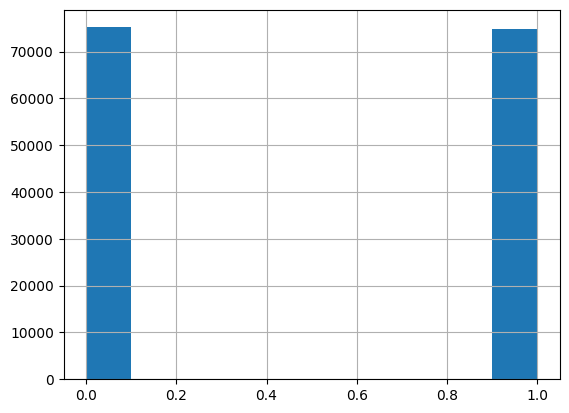

In [9]:
# 훈련 데이터
train_data['label'].hist()

<Axes: >

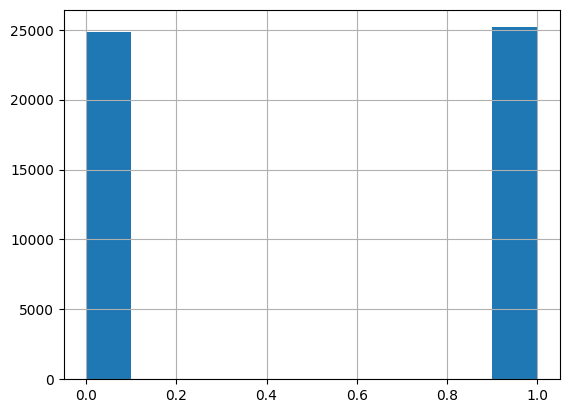

In [10]:
# TODO: 테스트 데이터 label 분포를 그려보세요.
test_data['label'].hist()

## 리뷰에서 한글과 공백만 남기기

In [11]:
# train_data 뒷부분 확인
train_data.tail(10)

,id,document,label
149990,6373651,이걸 영화라고 찎었냐?,0
149991,9492905,http://blog.naver.com/oroblast/220215679580 나쁜...,1
149992,9335962,공포나 재난영화가 아니라 아예 대놓고 비급 크리쳐개그물임ㅋㅋ 음악 완전 흥겹다ㅋ 5...,0
149993,10020916,For Carl.칼 세이건으로 시작해서 칼 세이건으로 끝난다.,1
149994,9458520,디케이드 다음에 더블 다음에 오즈인데 더블은 조금밖에 안나오네요.,1
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1
149999,9619869,한국 영화 최초로 수간하는 내용이 담긴 영화,0


In [12]:
# train_data의 document열에서 한글만 남기기, 즉 초성 (ㄱ부터 ㅎ까지), 중성 (ㅏ부터 ㅣ까지), 
# 음절(가부터 힣까지), 공백을 제외한 문자들을 ""로 변환
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)

# 위와 비교해보세요.
train_data.tail(10) 

,id,document,label
149990,6373651,이걸 영화라고 찎었냐,0
149991,9492905,나쁜 인상은 아니지만오랫동안 기억에 남아종종 떠올라서조금은 사람을 피곤하게 만드는...,1
149992,9335962,공포나 재난영화가 아니라 아예 대놓고 비급 크리쳐개그물임ㅋㅋ 음악 완전 흥겹다ㅋ 점...,0
149993,10020916,칼 세이건으로 시작해서 칼 세이건으로 끝난다,1
149994,9458520,디케이드 다음에 더블 다음에 오즈인데 더블은 조금밖에 안나오네요,1
149995,6222902,인간이 문제지 소는 뭔죄인가,0
149996,8549745,평점이 너무 낮아서,1
149997,9311800,이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다,0
149998,2376369,청춘 영화의 최고봉방황과 우울했던 날들의 자화상,1
149999,9619869,한국 영화 최초로 수간하는 내용이 담긴 영화,0


## 공백만 남은 리뷰 제거하기
한글이 없었던 리뷰는 공백으로 변했기 때문에 제거합니다.

In [13]:
train_data['document'] = train_data['document'].str.replace(' +$', "", regex=True) # 공백으로만 이루어진 리뷰를 ""로 변환
train_data['document'].replace('', np.nan, inplace=True) # ""를 nan값으로 변경
print(train_data.isnull().sum()) # nan인 개수 출력

id             0
document    1260
label          0
dtype: int64


In [14]:
# 훈련 데이터에서 nan값 지우기
train_data = train_data.dropna(how = 'any')
print(len(train_data))

148740


## 테스트 데이터 전처리하기
훈련 데이터와 동일하게 처리합니다.

In [15]:
# TODO: 한글과 공백만 남기기
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)

# TODO: 공백으로만 이루어진 리뷰 제거하기
test_data['document'] = test_data['document'].str.replace(' +$', "", regex=True)
test_data['document'].replace('', np.nan, inplace=True)
test_data = train_data.dropna(how = 'any')

## 형태소 분석
우리말은 영어와는 달리 공백만으로 단어를 완벽하게 분리해낼 수 없기 때문에 Okt (Open-korean-text)라는 형태소 분석기를 사용할 것입니다.<br>
Okt는 트위터에서 만든 오픈소스 한국어 처리기인 twitter-korean-text에서 파생됐습니다.

In [16]:
okt = Okt()

# 자연어처리에 사용하지 않을 불용어는 정의하기 나름인데 아래의 것들만 사용하겠습니다.
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [17]:
# 훈련 데이터 형태소 분석
X_train = []
for sentence in tqdm(train_data['document']): # document에서 리뷰 하나씩 가져오기, tqdm이 진행률을 보여줍니다.
    tokenized_sentence = okt.morphs(sentence, stem=True) # 하나의 리뷰 형태소 분석
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어를 제거
    X_train.append(stopwords_removed_sentence) # X_train에 형태소 분석한 리뷰 추가하기

100%|██████████| 148740/148740 [13:19<00:00, 186.09it/s]


In [18]:
# 형태소 분석 전후 비교
print(train_data['document'][:5])
np.array(X_train[:5], dtype=object)

0                                    아 더빙 진짜 짜증나네요 목소리
1                           흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                            교도소 이야기구먼 솔직히 재미는 없다평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...
Name: document, dtype: object


array([list(['아', '더빙', '진짜', '짜증나다', '목소리']),
       list(['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다']),
       list(['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']),
       list(['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정']),
       list(['사이', '몬페', '그', '익살스럽다', '연기', '돋보이다', '영화', '스파이더맨', '에서', '늙다', '보이다', '커스틴', '던스트', '너무나도', '이쁘다', '보이다'])],
      dtype=object)

In [23]:
X_test = []

# TODO: 테스트 데이터의 형태소를 분석하여 X_test에 저장하세요.
for sentence in tqdm(test_data['document']): # document에서 리뷰 하나씩 가져오기, tqdm이 진행률을 보여줍니다.
    tokenized_sentence = okt.morphs(sentence, stem=True) # 하나의 리뷰 형태소 분석
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어를 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 148740/148740 [14:41<00:00, 168.71it/s]


## 토큰화

In [24]:
# 10,000개의 단어만 사용해봅니다.
num_words = 10000

# TODO: X_train과 X_test 데이터를 합쳐서 적용합니다.
# Hint: 기존 NLP 노트북의 Tokenizer 참조
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train + X_test) #TODO

In [25]:
# 단어별 인덱스
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '을': 3, '없다': 4, '이다': 5, '있다': 6, '좋다': 7, '너무': 8, '다': 9, '정말': 10, '재밌다': 11, '되다': 12, '적': 13, '만': 14, '같다': 15, '진짜': 16, '로': 17, '아니다': 18, '않다': 19, '점': 20, '에서': 21, '만들다': 22, '나오다': 23, '연기': 24, '평점': 25, '것': 26, '최고': 27, '내': 28, '그': 29, '나': 30, '안': 31, '인': 32, '스토리': 33, '생각': 34, '못': 35, '왜': 36, '드라마': 37, '게': 38, '감동': 39, '사람': 40, '보고': 41, '이렇다': 42, '말': 43, '아깝다': 44, '고': 45, '더': 46, 'ㅋㅋ': 47, '배우': 48, '때': 49, '아': 50, '재미있다': 51, '감독': 52, '거': 53, '그냥': 54, '요': 55, '재미': 56, '시간': 57, '내용': 58, '뭐': 59, '까지': 60, '중': 61, '주다': 62, '재미없다': 63, '자다': 64, '쓰레기': 65, '하고': 66, '지루하다': 67, '네': 68, '수': 69, '모르다': 70, '가다': 71, '들다': 72, '그렇다': 73, '싶다': 74, '지': 75, '작품': 76, '사랑': 77, '알다': 78, '하나': 79, '다시': 80, '볼': 81, '마지막': 82, '이건': 83, '정도': 84, '저': 85, '완전': 86, 'ㅋ': 87, '오다': 88, 'ㅠㅠ': 89, '많다': 90, 'ㅋㅋㅋ': 91, '처음': 92, '장면': 93, '액션': 94, '주인공': 95, '이렇게': 96, '걸': 97, '안되다': 98, '차다': 99, '최악': 100, '나다': 101, '개': 

In [26]:
# 단어별 등장횟수
print(tokenizer.word_counts.items())

odict_items([('아', 8304), ('더빙', 1146), ('진짜', 16676), ('짜증나다', 2028), ('목소리', 750), ('흠', 512), ('포스터', 1144), ('보고', 9330), ('초딩', 848), ('영화', 101286), ('줄', 2482), ('오버', 284), ('연기', 12656), ('조차', 484), ('가볍다', 722), ('않다', 15456), ('너', 1342), ('무재', 138), ('밓었', 2), ('다그', 150), ('래서', 40), ('보다', 82288), ('추천', 2378), ('다', 20362), ('교도소', 32), ('이야기', 4348), ('구먼', 22), ('솔직하다', 2406), ('재미', 7842), ('없다', 31256), ('평점', 12630), ('조정', 80), ('사이', 444), ('몬페', 4), ('그', 11346), ('익살스럽다', 18), ('돋보이다', 578), ('스파이더맨', 128), ('에서', 13964), ('늙다', 396), ('보이다', 2156), ('커스틴', 8), ('던스트', 4), ('너무나도', 412), ('이쁘다', 2070), ('막', 666), ('걸음', 40), ('마', 474), ('떼다', 302), ('세', 1204), ('부터', 3446), ('초등학교', 232), ('학년', 242), ('생인', 12), ('살다', 2346), ('ㅋㅋㅋ', 4922), ('별', 3868), ('반개', 412), ('아깝다', 9092), ('움', 2122), ('원작', 2506), ('긴장감', 1664), ('을', 46524), ('제대로', 1592), ('살리다', 1068), ('욕', 1560), ('나오다', 12808), ('이응경', 16), ('길용우', 8), ('연', 1766), ('기', 3982), ('생활', 252),

In [27]:
# 훈련 데이터 토큰화하기
X_train_tokens = tokenizer.texts_to_sequences(X_train)

type(X_train_tokens), len(X_train_tokens)

(list, 148740)

In [28]:
# TODO: 테스트 데이터 토큰화하기
X_test_tokens = tokenizer.texts_to_sequences(X_test)

type(X_test_tokens), len(X_test_tokens)

(list, 148740)

In [29]:
# TODO: y값 설정하기, NumPy 배열로 만드세요.
# Hint: DataFrame에서 label 열을 가져오세요.
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

## 훈련 데이터에서 리뷰 길이 알아보기
인공신경망에 입력할 리뷰의 적정 길이를 알아봅시다.

In [30]:
# 각 리뷰에 단어 (토큰)가 몇 개씩 들어있는지 세어봅시다.
num_tokens = []

# TODO: num_tokens에 각 리뷰의 단어 숫자를 저장하세요.
# Hint: X_train[0]은 첫 번째 훈련 데이터의 단어들이 저장되어 있습니다. 그 길이는 len 함수로 알 수 있습니다.
for i in range(len(X_train_tokens)):
    num_tokens.append(len(X_train_tokens[i]))
    num_tokens.append(len(X_train_tokens[i]))
    
for i in range(len(X_test_tokens)):
    num_tokens.append(len(X_test_tokens[i]))
    num_tokens.append(len(X_test_tokens[i]))

In [31]:
# TODO: num_tokens 리스트를 num_tokens NumPy 배열로 변환하세요.
num_tokens = np.array(num_tokens)

In [32]:
# 모든 리뷰에서 사용한 평균 단어의 수는 다음과 같습니다.
np.mean(num_tokens)

10.300739545515665

In [33]:
# TODO: num_tokens에서 평균 + 2 * 표준편차를 구하여 우리가 허용할 최대 단어의 개수인 max_tokens를 설정해보세요.
# num_tokens가 정규분포를 따른다면 97% 이상이 max_tokens보다 적은 단어만을 사용할 것입니다.
# Hint: np.mean과 np.std 사용

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

27

In [34]:
# max_tokens보다 짧은 리뷰의 비율을 출력하는 코드
# 너무 적다고 생각되면 위에서 3 * 표준편차로 수정해보세요.
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.9290977544708888

In [35]:
# 전체 데이터의 길이를 max_tokens로 맞춘다.
# 기본이 'pre'로 설정되어 있습니다. 
X_train_pad = pad_sequences(X_train_tokens, maxlen=max_tokens)
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_tokens)

## 모델 생성

In [36]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

# TODO: 자유롭게 설정하세요.
embedding_size = 200 # 일반적으로 100에서 300
es = EarlyStopping(patience=5, restore_best_weights=True)

In [37]:
model = Sequential()
# 임베딩층 추가
model.add(Embedding(input_dim=num_words,      # 사용하는 단어의 개수
                    output_dim=embedding_size,# 임베딩 차원
                    input_length=max_tokens,  # 리뷰의 길이
                    name='layer_embedding'))

In [38]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-3)

# TODO: 자유롭게 생성하세요.
model.add(LSTM(units=256)) # GRU나 LSTM 사용 (여기에서는 LSTM이 좀 더 좋은 성능을 보이는 것 같음)
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

In [39]:
# 모델 훈련하기
model.fit(X_train_pad, y_train, epochs=10000, callbacks=es, batch_size=64, validation_split=0.2)

Epoch 1/10000
1860/1860 [==============================] - 445s 237ms/step - loss: 0.3830 - acc: 0.8265 - val_loss: 0.3452 - val_acc: 0.8503
Epoch 2/10000
1860/1860 [==============================] - 438s 235ms/step - loss: 0.3046 - acc: 0.8674 - val_loss: 0.3399 - val_acc: 0.8545
Epoch 3/10000
1860/1860 [==============================] - 443s 238ms/step - loss: 0.2626 - acc: 0.8875 - val_loss: 0.3669 - val_acc: 0.8515
Epoch 4/10000
1860/1860 [==============================] - 440s 237ms/step - loss: 0.2196 - acc: 0.9079 - val_loss: 0.3844 - val_acc: 0.8486
Epoch 5/10000
1860/1860 [==============================] - 436s 235ms/step - loss: 0.1802 - acc: 0.9264 - val_loss: 0.4432 - val_acc: 0.8441
Epoch 6/10000
1860/1860 [==============================] - 441s 237ms/step - loss: 0.1436 - acc: 0.9418 - val_loss: 0.4999 - val_acc: 0.8416
Epoch 7/10000
1860/1860 [==============================] - 436s 234ms/step - loss: 0.1147 - acc: 0.9543 - val_loss: 0.5780 - val_acc: 0.8348


In [40]:
# TODO: 테스트 데이터로 평가하기
# 85% 이상을 목표로 합시다.
%%time
result = model.evaluate(X_test_pad, y_test)
print("Accuracy: {0:.2%}".format(result[1]))

4649/4649 [==============================] - 180s 39ms/step - loss: 0.2778 - acc: 0.8892
Accuracy: 88.92%
CPU times: user 3min 58s, sys: 7.69 s, total: 4min 6s
Wall time: 2min 59s


## 새로운 리뷰 예측해보기

In [43]:
# 문자열을 입력하면 위에서 만든 model을 이용해 부정인지 긍정인지 예측해주는 함수

def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence) # 한글과 공백만 남기기
  new_sentence = okt.morphs(new_sentence, stem=True) # 형태소 분석
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 토큰화
  pad_new = pad_sequences(encoded, maxlen = max_tokens) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [44]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

1/1 [==============================] - 0s 465ms/step
82.09% 확률로 긍정 리뷰입니다.



In [45]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

1/1 [==============================] - 0s 27ms/step
97.39% 확률로 부정 리뷰입니다.



In [46]:
sentiment_predict('이딴게 영화냐 ㅉㅉ')

1/1 [==============================] - 0s 24ms/step
98.73% 확률로 부정 리뷰입니다.



In [47]:
sentiment_predict('감독 뭐하는 놈이냐?')

1/1 [==============================] - 0s 25ms/step
97.37% 확률로 부정 리뷰입니다.



In [48]:
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다')

1/1 [==============================] - 0s 24ms/step
64.35% 확률로 긍정 리뷰입니다.

